In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import pickle
import random

### Load in (correct) data

In [2]:
base_path = "C:/Users/Matt/Dropbox/SnowComp/"
path1 = base_path+"ModisSnowImagesT.npy"
path2 = base_path+"ModisSnowImagesA.npy"
path3 = base_path+"ModisSnowImages_subT.npy"
path4 = base_path+"ModisSnowImages_subA.npy"

train_dataT = np.load(path1)
train_dataA = np.load(path2)
# sub_dataT = np.load(path3) #be careful about memory, this is about 25-30 gigs ram
# sub_dataA = np.load(path4)

#load cell ids, note Ts are correct, As are actual daynums 
path_id = "C:/Users/Matt/Dropbox/SnowComp/cell_snow_idsT.pkl"
with open(path_id, 'rb') as handle:
    cell_ids = pickle.load( handle)
    
train_y = pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/train_labels.csv")

In [3]:
#labels helpers and processing
def pivot_df(df, id_col, ignore_cols=None):
    if not ignore_cols:
        ignore_cols = []
    date_cols = [x for x in df.columns if x not in [id_col] + ignore_cols]
    dfs = []
    for day in date_cols:
        day_df = df[[id_col, day]].rename({day: 'snowpack'}, axis=1)
        day_df['date'] = day
        dfs.append(day_df)
    return pd.concat(dfs)

def daynum_gen(date_time):
    '''converts date time objects to filename'''
    date_time = datetime.fromisoformat(date_time)
    doy = date_time.timetuple().tm_yday
    year = date_time.year
    return str(year) + '{:03d}'.format(doy)

train_y = pivot_df(train_y, 'cell_id').dropna()
train_y['date']=train_y['date'].map(daynum_gen)

In [4]:
#sort train_y so it has correct order before stripping labels
train_y['idx'] = train_y['cell_id'] +"-"+train_y['date']
sorter = [idx +"-" +date for  idx, date  in cell_ids]
train_y = train_y.set_index('idx')
train_y = train_y.loc[sorter]

#combine Aqua and Terra DSs
dataset = np.concatenate((train_dataT[:,0:1,:,:],train_dataA[:,0:1,:,:]), axis = 1)
# dataset = np.concatenate((train_dataT,train_dataA), axis = 1)

# #delete problematic columns
# dataset = np.delete(dataset, 3, 1) 
# dataset = np.delete(dataset, 9, 1)

dataset= dataset/255

del train_dataT
del train_dataA

# Basic pytorch CNN

In [5]:
#@title Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [6]:
# Do categorical preds to start (change)
train_y['cat'] = train_y['snowpack'].apply(lambda x: 1 if x > 15 else 0)
# dataset.shape, train_y.shape

In [7]:
#@title Define simple CNN
# From: https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html
# Also used: https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

START_D = 2
START_HW = 21

class Net(nn.Module):

    def _conv_calc(self, in_dim, pad, stride, k):
        out = int(np.floor((in_dim + 2 * pad - (k - 1) - 1) / stride + 1))
        return out

    def __init__(self, cdim1, cdim2,cdim3, kernel_sz, dropout,
                 ldim, print_dim = True):
        super(Net, self).__init__()
        
        #first layer
        self.conv1 = nn.Conv2d(2, cdim1, kernel_sz, 1)
        self.avgpool = nn.AvgPool2d(3, stride= 1)
        
        c1_dim = self._conv_calc(START_HW, 0, 1, kernel_sz)
        mp0_dim = self._conv_calc(c1_dim, 0, 1, 3)
        
        #second layer
        self.conv2 = nn.Conv2d(cdim1, cdim2, kernel_sz, 1)
        c2_dim = self._conv_calc(mp0_dim, 0, 1, kernel_sz)
        mp1_dim = self._conv_calc(c2_dim, 0, 1, 3)
        
        
        #third layer
        self.conv3 = nn.Conv2d(cdim2, cdim3, kernel_sz, 1)
        c3_dim = self._conv_calc(mp1_dim, 0, 1, kernel_sz)
        mp2_dim = self._conv_calc(c3_dim, 0, 1, 3)
        
        #fourth layer
        flattened_dim = cdim3 * mp2_dim * mp2_dim
        self.fc1 = nn.Linear(flattened_dim, ldim)
        self.fc2 = nn.Linear(ldim, 1)

        #extras
        self.dropout1 = nn.Dropout2d(dropout)
        self.dropout2 = nn.Dropout2d(dropout*2)
        self.BatchNorm1 = nn.BatchNorm2d(cdim1)
        self.BatchNorm3 = nn.BatchNorm2d(cdim3)
        
        if print_dim:
            print('c1 dim:', c1_dim)
            print('mp0 dim:', mp0_dim)
            print('c2 dim:', c2_dim)
            print('mp1 dim:', mp1_dim)
            print('c3 dim:', c3_dim)
            print('mp2 dim:', mp2_dim)
            print('flattened_dim',flattened_dim)
        
        
    def forward(self, x):
        #first layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.BatchNorm1(x)
        x = self.avgpool(x)
        
        #second layer
        x = self.dropout1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.avgpool(x)
        
        #third layer
        x = self.dropout2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.BatchNorm3(x)
        x = self.avgpool(x)
        
        #fourth layer
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        
        output = self.fc2(x)
        return output

    




In [8]:
#@title Helpers to get predictions and accuracy
def predict(cnn, x, as_numpy=False):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    cnn.eval()
    x =x.type(torch.FloatTensor).to(device)
    output = cnn(x)
    if as_numpy:
        output = output.flatten().cpu().detach().numpy() #detach removes gradients (bad)
        
    cnn.train()
    return output.squeeze()

def get_accuracy(cnn, x, y):
#     y = torch.from_numpy(y).to(device)
    outputs = predict(cnn, x,as_numpy = False)
    
#     print(y.shape, outputs.shape)
    loss = ((y-outputs)**2).sum()
    return round(loss.item(), 6)



In [9]:
#@title Test run
# my_nn = Net(cdim1=8, cdim2=8, kernel_sz=3, dropout=0.25, ldim=8)
# optimizer = optim.Adam(my_nn.parameters(), lr=0.1)
# optimizer.zero_grad()

# test_im = torch.from_numpy(dataset[0]).reshape(1, 14, 21, 21)
# result = my_nn(test_im.type(torch.FloatTensor))
# result.shape


In [10]:
#@title split training and testing

mask = np.random.rand(len(dataset)) < 0.9
training_data = dataset[mask]
testing_data = dataset[~mask]
train_rows = len(training_data)
test_rows = len(testing_data)

In [11]:
#@title Get data loaders
# train_dataset = TensorDataset(torch.Tensor(dataset),
#                               torch.Tensor(train_y['snowpack']))
# train_loader = DataLoader(train_dataset, batch_size=64)

# mini_x, mini_y = np.array(dataset)[:2,], np.array(train_y['snowpack'])[:2,]

test_x, test_y = np.array(dataset)[~mask], np.array(train_y['snowpack'])[~mask]
test_x, test_y = torch.Tensor(test_x), torch.Tensor(test_y)
test_dataset = TensorDataset(test_x,test_y)
test_loader = DataLoader(test_dataset, batch_size = 200)

mini_x, mini_y = np.array(dataset)[mask], np.array(train_y['snowpack'])[mask]
mini_x, mini_y = torch.Tensor(mini_x), torch.Tensor(mini_y)

mini_dataset = TensorDataset(mini_x,
                              mini_y)
mini_loader = DataLoader(mini_dataset, batch_size=200)

In [12]:
#@title Setup net
cdim1=32; cdim2=18;cdim3 =8; kernel_sz=3; dropout=0.13; ldim=50
my_nn = Net(cdim1=cdim1, cdim2=cdim2,cdim3 =cdim3, kernel_sz=kernel_sz, dropout=dropout, ldim=ldim)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"
)
my_nn.to(device)
optimizer = optim.Adam(my_nn.parameters(), lr=0.00005)
criterion = nn.MSELoss(reduction = 'sum')

writer = SummaryWriter('runs/cnn_full')
write_index = 0




c1 dim: 19
mp0 dim: 17
c2 dim: 15
mp1 dim: 13
c3 dim: 11
mp2 dim: 9
flattened_dim 648


In [13]:
N_EPOCHS = 45

test_loss = []
train_loss = []

#@title Run net
for epoch in range(N_EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(mini_loader, 0):
        optimizer.zero_grad()
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = my_nn(inputs).squeeze()
#         print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
#         for name, param in my_nn.named_parameters():
#             print(name, param.grad.abs().sum())

        running_loss += loss.item()
        if (i + 1) % 100 == 0:
            writer.add_scalar('Loss/train', running_loss , write_index)
        write_index += 1

#     val_acc = get_accuracy(my_nn, mini_x, mini_y)
    train_loss.append(running_loss/train_rows)
    writer.add_scalar('Acc/val', train_loss[-1], write_index)
    
    #calculate test loss.
    with torch.no_grad():
        
        running_tar_loss = 0
        for data, target in test_loader:
            running_tar_loss += get_accuracy(my_nn, data, target.to(device))


        test_loss.append(running_tar_loss / test_rows)
        writer.add_scalar('Test MSE', test_loss[-1], write_index)

    print(epoch, '/', N_EPOCHS,
          'complete, train:', round(np.sqrt(train_loss[-1]), 4),
          "test:", round(np.sqrt(test_loss[-1]), 4) )
            
            
            

    
    
writer.close()
print('Finished Training')

0 / 45 complete, train: 18.4245 test: 17.5202
1 / 45 complete, train: 16.0861 test: 15.0192
2 / 45 complete, train: 15.36 test: 14.7366
3 / 45 complete, train: 15.0579 test: 14.553
4 / 45 complete, train: 14.834 test: 14.3847
5 / 45 complete, train: 14.6748 test: 14.2882
6 / 45 complete, train: 14.5798 test: 14.2386
7 / 45 complete, train: 14.4596 test: 14.1969
8 / 45 complete, train: 14.3791 test: 14.1509
9 / 45 complete, train: 14.3352 test: 14.1488
10 / 45 complete, train: 14.2766 test: 14.1078
11 / 45 complete, train: 14.2273 test: 14.0928
12 / 45 complete, train: 14.1802 test: 14.0409
13 / 45 complete, train: 14.1034 test: 14.0583
14 / 45 complete, train: 14.0843 test: 14.0135
15 / 45 complete, train: 14.0544 test: 14.0729
16 / 45 complete, train: 14.0023 test: 14.0484
17 / 45 complete, train: 13.9551 test: 14.0701
18 / 45 complete, train: 13.9432 test: 14.0694
19 / 45 complete, train: 13.8931 test: 14.0624
20 / 45 complete, train: 13.9004 test: 14.0245
21 / 45 complete, train: 13

In [14]:
torch.cuda.empty_cache()


### Checking accuracy

In [15]:
# my_nn = my_nn.to('cpu')
# 

# print(np.sqrt(((vals.detach().numpy().flatten()  - mini_y.numpy())**2).mean()))

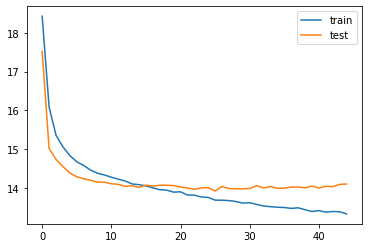

In [16]:
#really ugly code, sorry lol
path = "C:/Users/Matt/Dropbox/SnowComp/RunGraphs/converge" + "_" + \
    str(cdim1)+ "_" + str(cdim2)+ "_" +str(cdim3)+ "_" + str(kernel_sz)+ \
    "_" + str(dropout)+ "_" + str(ldim)+ "_" + str(epoch) 

plt.plot(range(epoch+1), np.sqrt(train_loss), label ="train")
plt.plot(range(epoch+1), np.sqrt(test_loss), label ="test")
plt.legend()
plt.savefig(path + ".png")

## Save Model and Predictions

In [19]:
my_nn.eval()
my_nn.to('cpu')

torch.save(my_nn.state_dict(), path)

In [22]:
with torch.no_grad():
    vals = my_nn(mini_x).detach().numpy()


In [26]:
path_preds = "C:/Users/Matt/Dropbox/SnowComp/preds/pred" 

suffix = "_" + \
    str(cdim1)+ "_" + str(cdim2)+ "_" +str(cdim3)+ "_" + str(kernel_sz)+ \
    "_" + str(dropout)+ "_" + str(ldim)+ "_" + str(epoch) 
np.save(path_preds+suffix, vals)


In [29]:
# del mini_x, mini_dataset, mini_loader

sub_dataT = np.load(path3) #be careful about memory, this is about 25-30 gigs ram
sub_dataA = np.load(path4)

sub_dataset = np.concatenate((sub_dataT[:,0:1,:,:],sub_dataA[:,0:1,:,:]), axis = 1)
sub_dataset = sub_dataset/255
sub_dataset = torch.Tensor(sub_dataset)

del sub_dataT, sub_dataA

In [ ]:
with torch.no_grad():
    vals_sub = my_nn(sub_dataset).detach().numpy()
    


## Things to check

1. Accuracy measures are right
2. Check missing value

### TODO:
- Add test set/cv
- Batchnorm?
- CNN benchmark